In [2]:
# !pip install xgboost
from xgboost import XGBClassifier
from sklearn.datasets import make_classification
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif, RFE, SelectFromModel, SelectKBest, mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, make_scorer, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

In [3]:
X = pd.read_csv('data/x_train.txt', sep=' ', header=None)
y = pd.read_csv('data/y_train.txt', sep=' ', header=None)

scaler = StandardScaler()
scaler.fit(X)
scaler.transform(X)

array([[ 1.13097047,  1.08072092,  1.73647145, ...,  1.8532937 ,
        -0.00237212, -0.68410529],
       [ 0.14207263, -0.57279616, -0.04017562, ..., -0.36721045,
        -0.33579041, -0.44394117],
       [-1.15152839, -0.49037662, -0.45042092, ...,  1.42187652,
        -1.39365561, -1.31475799],
       ...,
       [-1.14450907, -1.04049544, -1.46594797, ..., -0.53837807,
         0.96241795,  0.7448533 ],
       [ 1.7155432 ,  0.30967644,  0.44461471, ...,  0.40724653,
        -0.89767066,  0.20680596],
       [-0.25260128, -0.56633981, -0.44088539, ...,  0.15089201,
        -2.00568113,  0.94652768]])

Feature selection

C:\Users\user\AppData\Local\Temp\ipykernel_24288\3542368948.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X, y)


[0.00784358 0.01409059 0.04685515 0.01764742 0.01231726 0.01073747
 0.02039985 0.01281396 0.01700896 0.00815767 0.00130421 0.00201768
 0.00156884 0.00167827 0.00178164 0.00139666 0.00171633 0.00139558
 0.00125032 0.00173775 0.00167674 0.00149562 0.00165356 0.00120706
 0.00180762 0.00180088 0.00175542 0.00155576 0.00162173 0.00128482
 0.00221528 0.00151408 0.00169269 0.00179281 0.00164341 0.00168319
 0.00134951 0.0010344  0.00212897 0.00138883 0.00143298 0.00157454
 0.00177176 0.00134674 0.00152408 0.00152418 0.0016064  0.00153664
 0.00172265 0.00150236 0.00159314 0.00162727 0.00190467 0.00111926
 0.00188888 0.00172659 0.00176759 0.00138564 0.00173709 0.00174469
 0.00164078 0.0016427  0.00161795 0.00171304 0.00186493 0.00150766
 0.00167443 0.0016408  0.00205714 0.00177922 0.00172042 0.00164456
 0.00171109 0.00166223 0.00190272 0.00207287 0.00172468 0.0016876
 0.00224473 0.00136732 0.00146821 0.00215462 0.00190095 0.00190607
 0.00133462 0.00157613 0.0016355  0.00196127 0.00160807 0.00152

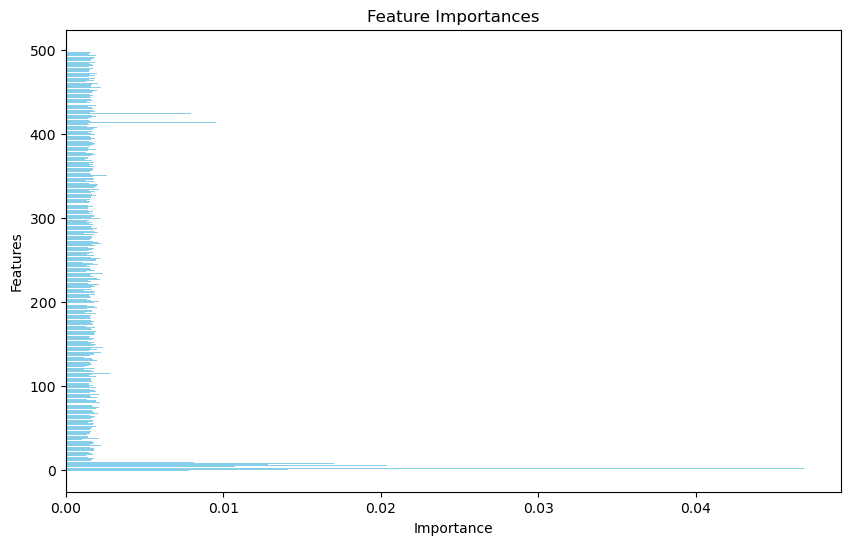

In [5]:
columns = range(0,500)
# EMBEDDED: ( Random Forest )
rf = RandomForestClassifier()
rf.fit(X, y)
importances = rf.feature_importances_
print(importances)
importances_sorted_indices = np.argsort(importances)[::-1]
feature_names_sorted = [columns[i] for i in importances_sorted_indices]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(feature_names_sorted, importances[importances_sorted_indices], color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()



In [6]:
threshold = [0.002, 0.003, 0.005, 0.007]
selected_features = []
for t in threshold:
    rf_selected = [columns[i] for i in range(len(columns)) if importances[i] > t]
    print(f'Features above importance of {t}: {rf_selected}')
    print('Number of features: ', len(rf_selected))
    selected_features.append(rf_selected)

Features above importance of 0.002: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 30, 38, 68, 75, 78, 81, 90, 115, 140, 146, 167, 191, 201, 221, 227, 228, 234, 245, 252, 270, 271, 283, 298, 300, 318, 334, 339, 340, 351, 367, 411, 414, 425, 436, 448, 456, 460, 462]
Number of features:  49
Features above importance of 0.003: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 414, 425, 462]
Number of features:  13
Features above importance of 0.005: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 414, 425, 462]
Number of features:  13
Features above importance of 0.007: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 414, 425, 462]
Number of features:  13


In [5]:
class MyAdaBoost(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator=None, depth=1, n_estimators=50):
        self.base_estimator = base_estimator
        self.depth = depth
        self.n_estimators = n_estimators
        self.models = []
        self.betas = []

        if self.base_estimator is None:
            self.base_estimator = DecisionTreeClassifier(max_depth=self.depth)

    def fit(self, X, y):
        y = np.ravel(y)  # guarantees 1D NumPy array
        n = X.shape[0]
        w = np.ones(n) / n

        for _ in range(self.n_estimators):
            model = clone(self.base_estimator)
            model.fit(X, y, sample_weight=w)
            y_pred = model.predict(X)

            miss = (y_pred != y)
            err = np.dot(w, miss)

            beta = err / (1 - err)

            self.models.append(model)
            self.betas.append(beta)

            w *= np.where(miss, 1, beta)
            w /= np.sum(w)
            
    def predict(self, X):
        classes = np.unique(self.models[0].predict(X))
        votes = np.zeros((X.shape[0], len(classes)))

        for model, beta in zip(self.models, self.betas):
            preds = model.predict(X)
            for i, c in enumerate(classes):
                votes[:, i] += (preds == c) * np.log(1 / beta)

        return classes[np.argmax(votes, axis=1)]
    
    def get_params(self, deep=True):
        return {
            "base_estimator": self.base_estimator,
            "depth": self.depth,
            "n_estimators": self.n_estimators
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        if "depth" in params:
            self.base_estimator = DecisionTreeClassifier(max_depth=params["depth"])
        return self

In [16]:

def custom_score(y_true, y_pred, n_features_used):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    accuracy = accuracy_score(y_true, y_pred)
    score = 10 * tp - 200 * n_features_used
    return score, accuracy


def model_search(X, y, models_with_params, feature_selectors, cv=4):

    X = X.to_numpy() if isinstance(X, pd.DataFrame) else np.asarray(X)
    y = np.asarray(y).ravel()

    best_score = -np.inf
    best_model = None
    best_features = None
    results = []

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    for selector_name, selector in feature_selectors.items():
        selector.fit(X, y)
        selected_mask = selector.get_support()
        X_sel = X[:, selected_mask]
        n_features = np.sum(selected_mask)

        for model_name, (model, param_grid) in models_with_params.items():
            for params in param_grid:
                model.set_params(**params)

                fold_scores = []
                fold_accuracies = []

                for train_idx, test_idx in skf.split(X_sel, y):
                    X_train, X_test = X_sel[train_idx], X_sel[test_idx]
                    y_train, y_test = y[train_idx], y[test_idx]

                    clf = clone(model)
                    clf.fit(X_train, y_train)
                    y_pred = clf.predict(X_test)

                    score, accuracy = custom_score(y_test, y_pred, n_features)
                    fold_scores.append(score)
                    fold_accuracies.append(accuracy
                                           )
                avg_score = np.mean(fold_scores)
                avg_accuracy = np.mean(fold_accuracies)
                results.append((avg_score, avg_accuracy, model_name, params, selector_name, n_features))

                if avg_score > best_score:
                    best_score = avg_score
                    best_accuracy = avg_accuracy
                    best_model = clone(model).set_params(**params).fit(X_sel, y)
                    best_features = np.where(selected_mask)[0]

    return best_model, best_features, best_score, best_accuracy, results

In [ ]:

C_vals = [0.01, 0.1, 1.0]
penalties = ['l1', 'l2']

n_estimators = [400, 500]
max_depth = [None, 3, 5]


models_with_params = {
    "LogisticRegression": (
        LogisticRegression(solver='liblinear', max_iter=500),  # 'liblinear' supports both l1 and l2
    [
        {"C": c, "penalty": p}
        for c, p in product(C_vals, penalties)
    ])

}


k_values = [2, 3, 4, 5, 6, 7, 8]

def build_selectors(X, y):
    X = X.to_numpy() if isinstance(X, pd.DataFrame) else np.asarray(X)
    y = np.asarray(y).ravel()

    selectors = {}

    # SelectKBest with k values
    for k in k_values:
        selectors[f"SelectKBest_k={k}"] = SelectKBest(score_func=mutual_info_classif, k=k)

    # Train base model for SelectFromModel
    base_rf = RandomForestClassifier(n_estimators=70, random_state=42)
    base_rf.fit(X, y)
    importances = base_rf.feature_importances_

    # Use percentile-based thresholds
    for p in [98.5, 99, 99.2, 99.5, 99.7]:
        threshold = np.percentile(importances, p)
        label = f"{p}th_percentile"
        selectors[f"SelectFromModel_thresh={label}"] = SelectFromModel(estimator=base_rf, threshold=threshold, prefit=True)

    return selectors


feature_selectors = build_selectors(X, y)
best_lr, best_lr_features, best_lr_score, best_lr_accuracy, all_lr_results = model_search(X, y, models_with_params, feature_selectors)

df_results_lr = pd.DataFrame(all_lr_results, columns=["Score", "Accuracy", "Model", "Params", "Feature_Selector", "Num_Features"])
df_results_lr.sort_values(by="Score", ascending=False).head(50)


,Score,Accuracy,Model,Params,Feature_Selector,Num_Features
1,4265.0,0.6918,LogisticRegression,"{'C': 0.01, 'penalty': 'l2'}",SelectKBest_k=2,2
67,4265.0,0.6918,LogisticRegression,"{'C': 0.01, 'penalty': 'l2'}",SelectFromModel_thresh=99.7th_percentile,2
0,4195.0,0.6996,LogisticRegression,"{'C': 0.01, 'penalty': 'l1'}",SelectKBest_k=2,2
66,4195.0,0.6996,LogisticRegression,"{'C': 0.01, 'penalty': 'l1'}",SelectFromModel_thresh=99.7th_percentile,2
7,4012.5,0.6892,LogisticRegression,"{'C': 0.01, 'penalty': 'l2'}",SelectKBest_k=3,3
61,4012.5,0.6892,LogisticRegression,"{'C': 0.01, 'penalty': 'l2'}",SelectFromModel_thresh=99.5th_percentile,3
6,3995.0,0.6996,LogisticRegression,"{'C': 0.01, 'penalty': 'l1'}",SelectKBest_k=3,3
60,3995.0,0.6996,LogisticRegression,"{'C': 0.01, 'penalty': 'l1'}",SelectFromModel_thresh=99.5th_percentile,3
12,3797.5,0.7014,LogisticRegression,"{'C': 0.01, 'penalty': 'l1'}",SelectKBest_k=4,4
54,3787.5,0.6986,LogisticRegression,"{'C': 0.01, 'penalty': 'l1'}",SelectFromModel_thresh=99.2th_percentile,4


In [ ]:


n_estimators = [400, 500]
max_depth = [None, 3, 5]


models_with_params = {

    "RandomForest": (
        RandomForestClassifier(),
        [{"n_estimators": n, "max_depth": d}
            for n, d in product(n_estimators, max_depth)]
    )
}


best_rf, best_rf_features, best_rf_score, best_rf_accuracy, all_rf_results = model_search(X, y, models_with_params, feature_selectors)

df_results_rf = pd.DataFrame(all_rf_results, columns=["Score", "Accuracy", "Model", "Params", "Feature_Selector", "Num_Features"])
df_results_rf.sort_values(by="Score", ascending=False).head(50)

,Score,Accuracy,Model,Params,Feature_Selector,Num_Features
4,3807.5,0.7042,RandomForest,"{'n_estimators': 500, 'max_depth': 3}",SelectKBest_k=2,2
70,3807.5,0.7048,RandomForest,"{'n_estimators': 500, 'max_depth': 3}",SelectFromModel_thresh=99.7th_percentile,2
1,3797.5,0.7034,RandomForest,"{'n_estimators': 400, 'max_depth': 3}",SelectKBest_k=2,2
67,3792.5,0.7042,RandomForest,"{'n_estimators': 400, 'max_depth': 3}",SelectFromModel_thresh=99.7th_percentile,2
71,3782.5,0.7008,RandomForest,"{'n_estimators': 500, 'max_depth': 5}",SelectFromModel_thresh=99.7th_percentile,2
2,3782.5,0.7010,RandomForest,"{'n_estimators': 400, 'max_depth': 5}",SelectKBest_k=2,2
68,3782.5,0.7002,RandomForest,"{'n_estimators': 400, 'max_depth': 5}",SelectFromModel_thresh=99.7th_percentile,2
5,3767.5,0.6994,RandomForest,"{'n_estimators': 500, 'max_depth': 5}",SelectKBest_k=2,2
61,3632.5,0.7064,RandomForest,"{'n_estimators': 400, 'max_depth': 3}",SelectFromModel_thresh=99.5th_percentile,3
7,3627.5,0.7064,RandomForest,"{'n_estimators': 400, 'max_depth': 3}",SelectKBest_k=3,3


In [ ]:


n_estimators = [400, 500]
max_depth = [None, 3, 5]


models_with_params = {

    "AdaBoost": ( MyAdaBoost(), 
    [{"n_estimators": n, "max_depth": d}
            for n, d in product(n_estimators, max_depth)]
    )
}


best_ab, best_ab_features, best_ab_score, best_ab_accuracy, all_ab_results = model_search(X, y, models_with_params, feature_selectors)

df_results_ab = pd.DataFrame(all_ab_results, columns=["Score", "Accuracy", "Model", "Params", "Feature_Selector", "Num_Features"])
df_results_ab.sort_values(by="Score", ascending=False).head(50)

,Score,Accuracy,Model,Params,Feature_Selector,Num_Features
0,3860.0,0.7060,AdaBoost,"{'n_estimators': 400, 'max_depth': None}",SelectKBest_k=2,2
1,3860.0,0.7060,AdaBoost,"{'n_estimators': 400, 'max_depth': 3}",SelectKBest_k=2,2
70,3860.0,0.7060,AdaBoost,"{'n_estimators': 500, 'max_depth': 3}",SelectFromModel_thresh=99.7th_percentile,2
69,3860.0,0.7060,AdaBoost,"{'n_estimators': 500, 'max_depth': None}",SelectFromModel_thresh=99.7th_percentile,2
68,3860.0,0.7060,AdaBoost,"{'n_estimators': 400, 'max_depth': 5}",SelectFromModel_thresh=99.7th_percentile,2
67,3860.0,0.7060,AdaBoost,"{'n_estimators': 400, 'max_depth': 3}",SelectFromModel_thresh=99.7th_percentile,2
66,3860.0,0.7060,AdaBoost,"{'n_estimators': 400, 'max_depth': None}",SelectFromModel_thresh=99.7th_percentile,2
71,3860.0,0.7060,AdaBoost,"{'n_estimators': 500, 'max_depth': 5}",SelectFromModel_thresh=99.7th_percentile,2
2,3860.0,0.7060,AdaBoost,"{'n_estimators': 400, 'max_depth': 5}",SelectKBest_k=2,2
3,3860.0,0.7060,AdaBoost,"{'n_estimators': 500, 'max_depth': None}",SelectKBest_k=2,2


In [ ]:


n_estimators = [400, 500]
max_depth = [None, 3, 5]


models_with_params = {

    "GradientBoostingClassifier": (
        GradientBoostingClassifier(),
        [{"n_estimators": n, "max_depth": d}
             for n, d in product(n_estimators, max_depth)]
    )
}


best_gb, best_gb_features, best_gb_score, best_gb_accuracy, all_gb_results = model_search(X, y, models_with_params, feature_selectors)

df_results_gb = pd.DataFrame(all_gb_results, columns=["Score", "Accuracy", "Model", "Params", "Feature_Selector", "Num_Features"])
df_results_gb.sort_values(by="Score", ascending=False).head(50)

,Score,Accuracy,Model,Params,Feature_Selector,Num_Features
1,3697.5,0.6834,GradientBoostingClassifier,"{'n_estimators': 400, 'max_depth': 3}",SelectKBest_k=2,2
67,3697.5,0.6832,GradientBoostingClassifier,"{'n_estimators': 400, 'max_depth': 3}",SelectFromModel_thresh=99.7th_percentile,2
70,3662.5,0.6806,GradientBoostingClassifier,"{'n_estimators': 500, 'max_depth': 3}",SelectFromModel_thresh=99.7th_percentile,2
4,3662.5,0.6804,GradientBoostingClassifier,"{'n_estimators': 500, 'max_depth': 3}",SelectKBest_k=2,2
68,3592.5,0.6648,GradientBoostingClassifier,"{'n_estimators': 400, 'max_depth': 5}",SelectFromModel_thresh=99.7th_percentile,2
2,3560.0,0.6628,GradientBoostingClassifier,"{'n_estimators': 400, 'max_depth': 5}",SelectKBest_k=2,2
71,3557.5,0.6614,GradientBoostingClassifier,"{'n_estimators': 500, 'max_depth': 5}",SelectFromModel_thresh=99.7th_percentile,2
5,3545.0,0.6572,GradientBoostingClassifier,"{'n_estimators': 500, 'max_depth': 5}",SelectKBest_k=2,2
61,3517.5,0.6886,GradientBoostingClassifier,"{'n_estimators': 400, 'max_depth': 3}",SelectFromModel_thresh=99.5th_percentile,3
7,3500.0,0.6866,GradientBoostingClassifier,"{'n_estimators': 400, 'max_depth': 3}",SelectKBest_k=3,3


In [ ]:


n_estimators = [300, 400, 500]
max_depth = [None, 3, 5]


models_with_params = {

    "BaggingClassifier": (
        BaggingClassifier(),
        [{"n_estimators": n}
             for n in n_estimators]
    )
}


best_bc, best_bc_features, best_bc_score, best_bc_accuracy, all_bc_results = model_search(X, y, models_with_params, feature_selectors)

df_results_bc = pd.DataFrame(all_bc_results, columns=["Score", "Accuracy", "Model", "Params", "Feature_Selector", "Num_Features"])
df_results_bc.sort_values(by="Score", ascending=False).head(50)

,Score,Accuracy,Model,Params,Feature_Selector,Num_Features
34,3517.5,0.6458,BaggingClassifier,{'n_estimators': 400},SelectFromModel_thresh=99.7th_percentile,2
35,3515.0,0.6426,BaggingClassifier,{'n_estimators': 500},SelectFromModel_thresh=99.7th_percentile,2
2,3507.5,0.6436,BaggingClassifier,{'n_estimators': 500},SelectKBest_k=2,2
33,3505.0,0.6458,BaggingClassifier,{'n_estimators': 300},SelectFromModel_thresh=99.7th_percentile,2
1,3502.5,0.6434,BaggingClassifier,{'n_estimators': 400},SelectKBest_k=2,2
0,3482.5,0.6398,BaggingClassifier,{'n_estimators': 300},SelectKBest_k=2,2
5,3482.5,0.6740,BaggingClassifier,{'n_estimators': 500},SelectKBest_k=3,3
4,3472.5,0.6742,BaggingClassifier,{'n_estimators': 400},SelectKBest_k=3,3
30,3472.5,0.6746,BaggingClassifier,{'n_estimators': 300},SelectFromModel_thresh=99.5th_percentile,3
32,3462.5,0.6724,BaggingClassifier,{'n_estimators': 500},SelectFromModel_thresh=99.5th_percentile,3


We check the influence of the number of features on the score and accuracy

In [87]:
df_results_num_features = pd.DataFrame(all_results, columns=["Score", "Accuracy", "Model", "Params", "Feature_Selector", "Num_Features"])
df_results_num_features.sort_values(by="Score", ascending=False).head(100)

,Score,Accuracy,Model,Params,Feature_Selector,Num_Features
3,1816.0,0.7080,RandomForest,"{'n_estimators': 400, 'max_depth': 3}",SelectKBest_k=8,8
5,1808.0,0.7074,RandomForest,"{'n_estimators': 600, 'max_depth': 3}",SelectKBest_k=8,8
1,1796.0,0.7070,RandomForest,"{'n_estimators': 200, 'max_depth': 3}",SelectKBest_k=8,8
0,1712.0,0.6996,RandomForest,"{'n_estimators': 200, 'max_depth': 1}",SelectKBest_k=8,8
4,1700.0,0.6984,RandomForest,"{'n_estimators': 600, 'max_depth': 1}",SelectKBest_k=8,8
2,1680.0,0.6958,RandomForest,"{'n_estimators': 400, 'max_depth': 1}",SelectKBest_k=8,8
53,1438.0,0.7114,RandomForest,"{'n_estimators': 600, 'max_depth': 3}",SelectFromModel_thresh=98th_percentile,10
49,1434.0,0.7102,RandomForest,"{'n_estimators': 200, 'max_depth': 3}",SelectFromModel_thresh=98th_percentile,10
51,1430.0,0.7098,RandomForest,"{'n_estimators': 400, 'max_depth': 3}",SelectFromModel_thresh=98th_percentile,10
50,1338.0,0.7012,RandomForest,"{'n_estimators': 400, 'max_depth': 1}",SelectFromModel_thresh=98th_percentile,10


Compare performance of top models on same subsets of data

In [ ]:
def model_search_1(X, y, models_with_params, feature_selectors, test_size=0.3, random_state=42):
    X = X.to_numpy() if isinstance(X, pd.DataFrame) else np.asarray(X)
    y = np.asarray(y).ravel()

    best_score = -np.inf
    best_model = None
    best_features = None
    best_accuracy = None
    results = []

    # Use one consistent data split for all selector/model runs
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    for selector_name, selector in feature_selectors.items():
        # Fit selector on training data only (to avoid leakage)
        selector.fit(X_train, y_train)
        selected_mask = selector.get_support()
        n_features = np.sum(selected_mask)

        # Apply mask to both sets
        X_train_sel = X_train[:, selected_mask]
        X_test_sel = X_test[:, selected_mask]

        for model_name, (model, param_grid) in models_with_params.items():
            for params in param_grid:
                model.set_params(**params)

                clf = clone(model)
                clf.fit(X_train_sel, y_train)
                y_pred = clf.predict(X_test_sel)

                score, accuracy = custom_score(y_test, y_pred, n_features)
                results.append((score, accuracy, model_name, params, selector_name, n_features))

                if score > best_score:
                    best_score = score
                    best_accuracy = accuracy
                    # retrain on full data with selected features
                    X_all_sel = X[:, selected_mask]
                    best_model = clone(model).set_params(**params).fit(X_all_sel, y)
                    best_features = np.where(selected_mask)[0]

    return best_model, best_features, best_score, best_accuracy, results

k_values = [2, 4, 6, 8]

def build_selectors_1(X, y):
    X = X.to_numpy() if isinstance(X, pd.DataFrame) else np.asarray(X)
    y = np.asarray(y).ravel()

    selectors = {}

    # SelectKBest with k values
    for k in k_values:
        selectors[f"SelectKBest_k={k}"] = SelectKBest(score_func=mutual_info_classif, k=k)

    # Train base model for SelectFromModel
    base_rf = RandomForestClassifier(n_estimators=70, random_state=42)
    base_rf.fit(X, y)
    importances = base_rf.feature_importances_

    # Use percentile-based thresholds
    for p in [99, 99.7]:
        threshold = np.percentile(importances, p)
        label = f"{p}th_percentile"
        selectors[f"SelectFromModel_thresh={label}"] = SelectFromModel(estimator=base_rf, threshold=threshold, prefit=True)

    return selectors


models_with_params_1 = {
    "LogisticRegression": (
        LogisticRegression(solver='liblinear', max_iter=500),  # 'liblinear' supports both l1 and l2
    [
        {"C": 0.1, "penalty": p}
        for p in ['l1', 'l2']
    ])
    ,
    "RandomForest": (
        RandomForestClassifier(),
        [{"n_estimators": n, "max_depth": d}
            for n, d in product([400, 500], [None, 3, 5])]
    ),
    "AdaBoost": ( MyAdaBoost(), 
    [{"n_estimators": n, "max_depth": d}
            for n, d in product([400, 500], [None, 3, 5])]
    ),
    "GradientBoostingClassifier": (
        GradientBoostingClassifier(),
        [{"n_estimators": n, "max_depth": d}
             for n, d in product([400, 500], [None, 3, 5])]
    ),
    "BaggingClassifier": (
        BaggingClassifier(),
        [{"n_estimators": n}
             for n in [400, 500]]
    )
}
feature_selectors_1 = build_selectors_1(X, y)
#print(feature_selectors)
best_model_1, best_features_1, best_score_1, best_accuracy_1, all_results_1 = model_search_1(X, y, models_with_params_1, feature_selectors_1)


df_results_1 = pd.DataFrame(all_results_1, columns=["Score", "Accuracy", "Model", "Params", "Feature_Selector", "Num_Features"])
df_results_1.sort_values(by="Score", ascending=False).head(100)

{'SelectKBest_k=2': SelectKBest(k=2,
            score_func=<function mutual_info_classif at 0x00000242460982C0>), 'SelectKBest_k=3': SelectKBest(k=3,
            score_func=<function mutual_info_classif at 0x00000242460982C0>), 'SelectKBest_k=4': SelectKBest(k=4,
            score_func=<function mutual_info_classif at 0x00000242460982C0>), 'SelectKBest_k=5': SelectKBest(k=5,
            score_func=<function mutual_info_classif at 0x00000242460982C0>), 'SelectKBest_k=6': SelectKBest(k=6,
            score_func=<function mutual_info_classif at 0x00000242460982C0>), 'SelectKBest_k=7': SelectKBest(k=7,
            score_func=<function mutual_info_classif at 0x00000242460982C0>), 'SelectKBest_k=8': SelectKBest(k=8,
            score_func=<function mutual_info_classif at 0x00000242460982C0>), 'SelectFromModel_thresh=98.5th_percentile': SelectFromModel(estimator=RandomForestClassifier(n_estimators=70,
                                                 random_state=42),
                prefit=T

,Score,Accuracy,Model,Params,Feature_Selector,Num_Features
123,4780,0.712000,AdaBoost,"{'n_estimators': 500, 'max_depth': 5}",SelectFromModel_thresh=99.7th_percentile,2
122,4780,0.712000,AdaBoost,"{'n_estimators': 500, 'max_depth': 3}",SelectFromModel_thresh=99.7th_percentile,2
121,4780,0.712000,AdaBoost,"{'n_estimators': 500, 'max_depth': None}",SelectFromModel_thresh=99.7th_percentile,2
120,4780,0.712000,AdaBoost,"{'n_estimators': 400, 'max_depth': 5}",SelectFromModel_thresh=99.7th_percentile,2
119,4780,0.712000,AdaBoost,"{'n_estimators': 400, 'max_depth': 3}",SelectFromModel_thresh=99.7th_percentile,2
...,...,...,...,...,...,...
64,3780,0.702667,BaggingClassifier,{'n_estimators': 400},SelectKBest_k=6,6
65,3780,0.699333,BaggingClassifier,{'n_estimators': 500},SelectKBest_k=6,6
59,3770,0.694000,GradientBoostingClassifier,"{'n_estimators': 400, 'max_depth': 3}",SelectKBest_k=6,6
107,3710,0.666000,GradientBoostingClassifier,"{'n_estimators': 500, 'max_depth': 5}",SelectFromModel_thresh=99th_percentile,5


In [27]:
df_results_total_1 = pd.DataFrame(all_results_1, columns=["Score", "Accuracy", "Model", "Params", "Feature_Selector", "Num_Features"])
df_results_total_1.sort_values(by="Accuracy", ascending=False).head(50)

,Score,Accuracy,Model,Params,Feature_Selector,Num_Features
48,3970,0.723333,RandomForest,"{'n_estimators': 400, 'max_depth': 5}",SelectKBest_k=6,6
51,3950,0.722667,RandomForest,"{'n_estimators': 500, 'max_depth': 5}",SelectKBest_k=6,6
26,4370,0.721333,RandomForest,"{'n_estimators': 400, 'max_depth': 5}",SelectKBest_k=4,4
95,4090,0.721333,RandomForest,"{'n_estimators': 500, 'max_depth': 5}",SelectFromModel_thresh=99th_percentile,5
92,4100,0.720667,RandomForest,"{'n_estimators': 400, 'max_depth': 5}",SelectFromModel_thresh=99th_percentile,5
44,3670,0.720667,LogisticRegression,"{'C': 0.1, 'penalty': 'l1'}",SelectKBest_k=6,6
22,4050,0.720000,LogisticRegression,"{'C': 0.1, 'penalty': 'l1'}",SelectKBest_k=4,4
29,4350,0.720000,RandomForest,"{'n_estimators': 500, 'max_depth': 5}",SelectKBest_k=4,4
88,3830,0.717333,LogisticRegression,"{'C': 0.1, 'penalty': 'l1'}",SelectFromModel_thresh=99th_percentile,5
70,3500,0.717333,RandomForest,"{'n_estimators': 400, 'max_depth': 5}",SelectKBest_k=8,8


Take the variant: 4370	0.721333	RandomForest	{'n_estimators': 400, 'max_depth': 5}	SelectKBest_k=4	4

In [ ]:
X_final = pd.read_csv('data/x_test.txt', sep=' ', header=None)
scaler.transform(X_final)

X = X.to_numpy() if isinstance(X, pd.DataFrame) else np.asarray(X)
y = np.asarray(y).ravel()

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )

selector = SelectKBest(score_func=mutual_info_classif, k=4)
selector.fit(X_train, y_train)
mask = selector.get_support()
selected_features = selector.get_support(indices=True)
n_features = mask.sum()

X_train_sel = X_train[:, mask]
X_test_sel  = X_test[:, mask]


print("Features selected")
model = RandomForestClassifier(n_estimators=400, max_depth=5)
model.fit(X_train_sel, y_train)
y_pred = model.predict(X_test_sel)
score, accuracy = custom_score(y_test, y_pred, n_features)
print(f"Score: {score}, accuracy: {accuracy}")

print("\nAll features ")
model = RandomForestClassifier(n_estimators=400, max_depth=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score, accuracy = custom_score(y_test, y_pred, 500)
print(f"Score: {score}, accuracy: {accuracy}")

Features selected
Score: 4380, accuracy: 0.724

All features 
Score: -95050, accuracy: 0.7013333333333334


In [ ]:
X_final = X_final.to_numpy() if isinstance(X_final, pd.DataFrame) else np.asarray(X_final)
X_final_sel  = X_final[:, mask]
X_sel = X[:, mask]

print(f"Final features selected: {n_features}")
model = RandomForestClassifier(n_estimators=400, max_depth=5)
model.fit(X_sel, y)
y_proba = model.predict_proba(X_final_sel)[:, 1]

# Select top 1000 indices
top_1000_indices = np.argsort(y_proba)[-1000:]  # ascending → take last 1000

np.savetxt("312889_obs.txt", top_1000_indices, fmt='%d')

# best_features should be a NumPy array of column indices
np.savetxt("312889_vars.txt", selected_features, fmt='%d')

Final features selected: 4
